## LSTM neural networks in stock marked prediction.

We test the performance of a simple LSTM model in predicting the stock market and compare it to a random-walk model. We also discuss some of the problems using LSTM in the context of stock marked prediction.
We chose cryptocurrencies as our object of analysis, namely Bitcoin. The reason we chose cryptocurrencies is because of the recent popularity.

Let's first do some simple analysis on the data. The data were scrapped from finance.yahoo.com.


In [142]:
#needed libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt


We will be using volume, opening and closing prices for our analysis.

In [143]:
url = 'https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/BTC-USD.csv'
BTC = pd.read_csv(url,skip_blank_lines=False).dropna()[["Date","Volume","Open","Close"]]
BTC.head(4)

,Date,Volume,Open,Close
0,2014-09-17,21056800,465.864014,457.334015
1,2014-09-18,34483200,456.859985,424.440002
2,2014-09-19,37919700,424.102997,394.795990
3,2014-09-20,36863600,394.673004,408.903992


In [144]:
BTC.tail(4)

,Date,Volume,Open,Close
2292,2020-12-26,48332647295,24677.015625,26437.037109
2293,2020-12-27,66479895605,26439.373047,26272.294922
2294,2020-12-28,49056742893,26280.822266,27084.808594
2295,2020-12-29,46253891584,26232.953125,26609.701172


Plotting the closing values shows us the high volatility of the BTC prices, which makes them a good candidate for day trading if we could predict the price changes. For our LSTM model to work at all, we need the prices to not be a random walk, meaning that the stock-price change during a period correlates with the stock-price change during a previous period. In other words our stocks follow certain recurring trends that our LSTM model is abel to pick up.
The extreme changes in the prices are a bit atypical for a pure random walk.

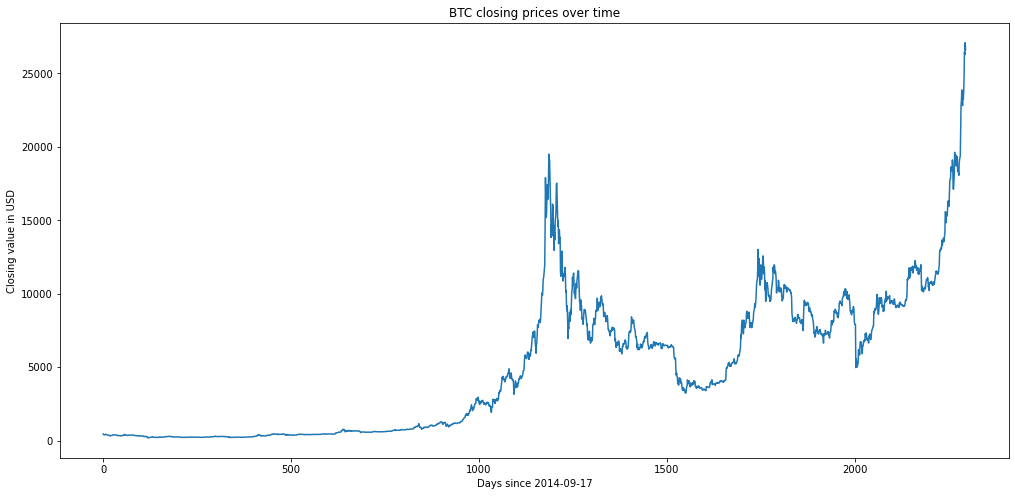

In [159]:
fig, ax = plt.subplots(figsize=(17, 8))
ax.set_xlabel("Days since 2014-09-17")
ax.set_ylabel("Closing value in USD")
asd = BTC.plot(y="Close",ax=ax,kind="line",title="BTC closing prices over time",legend=False,)

Lets look at the prices of another cryptocurrency.

In [10]:
url = 'https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/LTC-USD.csv'
LTC = pd.read_csv(url,skip_blank_lines=False).dropna()[["Date","Volume","Open","Close"]]

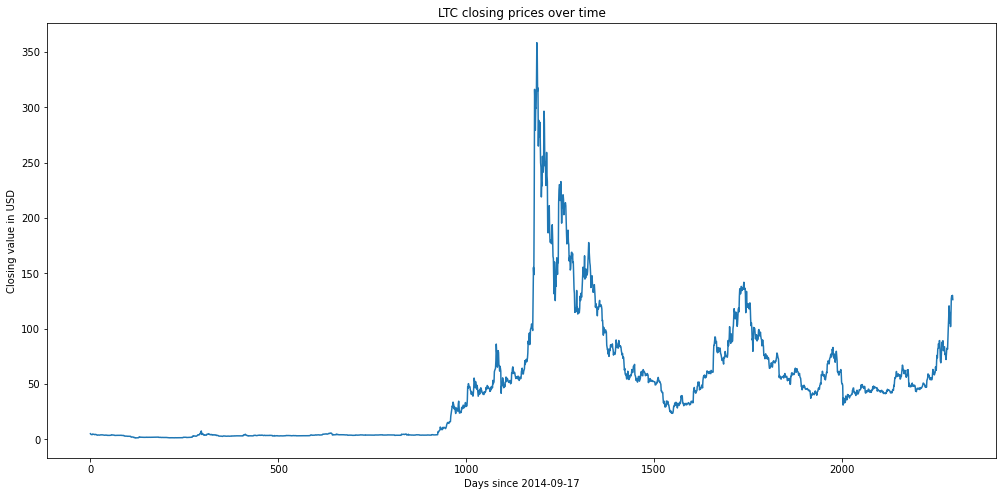

In [160]:
fig, ax = plt.subplots(figsize=(17, 8))
ax.set_xlabel("Days since 2014-09-17")
ax.set_ylabel("Closing value in USD")
asd = LTC.plot(y="Close",ax=ax,kind="line",title="LTC closing prices over time",legend=False,)

We see that the prices follow a similar pattern. Indeed the price changes of some cryptocurrencies are highly correlated which indicates that there might be a common trend (the trend can also be purely random of course). In case of LTC and BTC the correlation is C=0.7237.
Lets take a look at Correlation-Matrix of all the cryptocurrencies listed on finance.yahoo.com.

In [208]:
#We are interested in correlations from 2017-09-19 till 2020-12-29
start=1100
end=2295
#We load an entry list of all the cryptodata we have and sort the list by total volume size of the respective currencies.
df = pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/fListe.csv',index_col=False,header=None)
dates=list(pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/'+df.iat[0, 0][df.iat[0, 0].find("=")+1:]+".csv",skip_blank_lines=False)["Date"])
N=len(df.columns)
liste=[]
templist=[]
df1 = pd.DataFrame()

df.T.iloc[0:5, 0] #The list contains links finance.yahoo.com+list-entry.

0      /quote/BTC-USD?p=BTC-USD
1      /quote/ETH-USD?p=ETH-USD
2    /quote/USDT-USD?p=USDT-USD
3      /quote/XRP-USD?p=XRP-USD
4      /quote/LTC-USD?p=LTC-USD
Name: 0, dtype: object

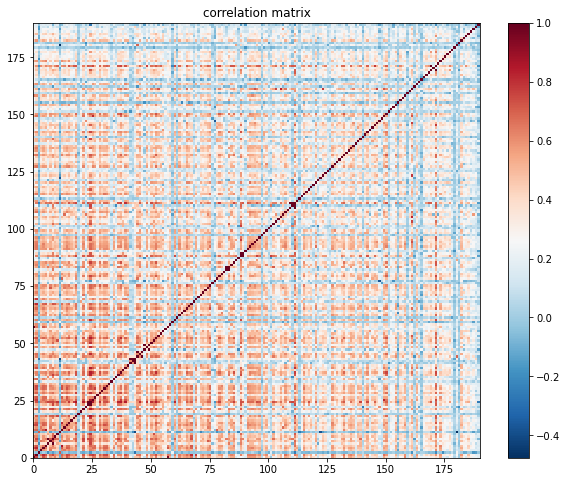

In [209]:

for i in range(N):
    if df.iat[1, i]=='OK': #Some entries on the list could not be successfully scrapped so we filter them out.
        df2 = pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/'+df.iat[0, i][df.iat[0, i].find("=")+1:]+".csv",skip_blank_lines=False)[["Volume"]]
        templist.append(df2.sum())
    else:
        templist.append(df2.sum()*0)
        
tempframe = pd.DataFrame(templist)
df = df.append(tempframe.transpose(),ignore_index=True)
df = df.sort_values(by=1, ascending=False, axis=1)

#Here we generalize the opening and closing values by calculating C=(open - close) / (open + close). This gives us values 
#between 1 and -1 indicating price changes. We will use the same generalization for our LSTM model.

for i in range(N): 
    if df[i][1]=='OK': #Check if the data is available
        check=pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/'+df[i][0][df[i][0].find("=")+1:]+".csv",skip_blank_lines=False)[["Date","Volume","Close"]]
        templist=list(set(check["Date"]) & set(dates[start:end])) 
        if check[check["Date"].isin(templist)]["Volume"][-11:-1].sum()>5000000: #We filter out very small or dying cryptocurrencies.        
            df2 = pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/'+df[i][0][df[i][0].find("=")+1:]+".csv",skip_blank_lines=False)
            df2 = pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/'+df[i][0][df[i][0].find("=")+1:]+".csv",skip_blank_lines=False)[df2["Date"].isin(templist)]
            df2=pd.concat([df2["Date"], (df2["Open"] - df2["Close"])/(df2["Open"] + df2["Close"])], axis=1).set_index(df2.columns[0])
            df1=pd.concat([df1, df2], axis=1)
            liste.append(df[i][0][df[i][0].find("=")+1:]) 
        
#Now we can calculate the correlation matrix and print it out.         
df1.columns = liste
color_map = plt.cm.get_cmap('RdBu')
reversed_color_map = color_map.reversed()  
mat=df1.corr()
plt.figure(figsize=(10,8))
plt.pcolormesh(mat, cmap=reversed_color_map)
plt.title("correlation matrix")
asd = plt.colorbar()


The colours indicate correlation strength and the axis numbers represent the cryptocurrencies sorted by total trading volume with 0 being the largest.
We can see that especially the larger currencies tend to correlate with each other indicating that there is a common trend.


Our price change calculation is basically equivalent to calculating the returns of a stock, so it might be useful to look at their distribution.

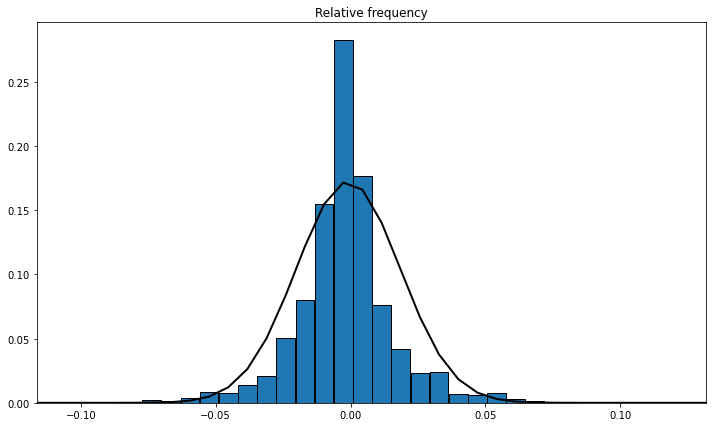

In [206]:
C = pd.concat([BTC["Date"], (BTC["Open"] - BTC["Close"])/(BTC["Open"]+BTC["Close"] )], axis=1).set_index(BTC.columns[0])
C = C.dropna()

bins=50
res = stats.relfreq(C.values, numbins=bins)
x = res.lowerlimit + np.linspace(0., res.binsize*res.frequency.size ,res.frequency.size)
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x, res.frequency, width=res.binsize,edgecolor="black")
ax.set_title('Relative frequency')
ax.set_xlim([x.min(), x.max()-.1])
mu, std = norm.fit(C.values)
p = norm.pdf(x, mu, std)/(bins*2.4) #the (bins*2.4) is for scaling (we have 2400 values thus the 2.4)
ax.plot(x, p, 'k', linewidth=2)
plt.show()




We see that the distribution resembles a Gaussian (besides one outlier) that is slightly tilted into the negative value range, which means that on average the stock is growing (negative values mean higher returns). A Gaussian distribution indicates independence of the samples.

## Building the model.

Our model is a simple LSTM layer, followed by a dense layer to interpret the LSTM output.

In [210]:
def Model(Hunits,Batchsize, uniq):
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(Hunits,return_sequences=True,batch_input_shape=[Batchsize, None,1],stateful=True,recurrent_initializer='glorot_uniform', activation="tanh"),
    tf.keras.layers.Dense(uniq, activation="sigmoid")
  ])
  return model

Now we need to bring our data to the right format to feed to our model. Our training data contains samples from 2016-11-23 to 2020-12-29.

In [214]:
TrainData = C
TrainData = TrainData.iloc[800:] # we are not interested at the very early stages of BTC.

#We define a function to discretize our Training data.
def Transform(Str):
    Discrete = ((Str)*100).round(0)  
    intervalls = np.sort(Discrete[0].unique())
    Discrete = Discrete.replace(intervalls, np.arange(Discrete[0].value_counts().shape[0]))
    return Discrete, intervalls

#This function transforms testdata based on our trainingsamples by chosing the same descrete set in the previous function.
def Transform2(Str, intervalls):
    Discrete = ((Str)*100).round(0)
    temp = intervalls
    intervalls = np.concatenate(([-100], np.append(intervalls,100)))
    Discrete = Discrete.replace(np.arange(intervalls[0],intervalls[1]) , intervalls[1])
    Discrete = Discrete.replace(np.arange(intervalls[-2],intervalls[-1]) , intervalls[-2])
    
    for i in range(1,intervalls.shape[0]-1):
        Discrete = Discrete.replace(np.arange( intervalls[i]-(np.absolute(intervalls[i-1]-intervalls[i])//2) ,intervalls[i]+(np.absolute(intervalls[i+1]-intervalls[i])//2)+(np.absolute(intervalls[i+1]-intervalls[i])%2) )  , intervalls[i])

    Discrete = Discrete.replace(temp, np.arange(temp.shape[0]))

    return Discrete

#And finally a function to reverse the Transformation as good as possible.
def ReTransform2(Str, intervalls):  
    Str = Str.replace(np.arange(intervalls.shape[0]), intervalls)
    return Str

TrainData, intervalls = Transform(TrainData)
uniques = TrainData[0].value_counts()#Number of discrete variabels.


In [217]:
#We feed the model data in intervalls of 30 days.
workingDay=30
batchSize=3

Dset = tf.data.Dataset.from_tensor_slices(TrainData[0]).batch(workingDay+5, drop_remainder=True)
#The way we train our model is to show it the first 1-30 days and expect it to output the 5-35 days so that it learns to predict 5 days.
#This method is very simmilar to how you would train a model to create artificial text.
def split(chunk):
    input_text = chunk[:-5]  
    input_text = tf.reshape(input_text, [workingDay,1])
    target_text = chunk[5:]  
    target_text = tf.reshape(target_text, [workingDay,1])
    return input_text, target_text 

Dset = Dset.map(split)
Dset = Dset.shuffle(100000).batch(batchSize, drop_remainder=True)

In [219]:
#Compiling the model and defining a loss function.
model = Model(1024,batchSize,uniques.shape[0])
model.summary()

def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss, metrics=[loss])
#we also save the best results for our model parameters
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='loss',
    mode='min',
    save_weights_only=True,
    save_best_only = True
    )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (3, None, 1024)           4202496   
_________________________________________________________________
dense_4 (Dense)              (3, None, 22)             22550     
Total params: 4,225,046
Trainable params: 4,225,046
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#history = model.fit(Dset, epochs=250, callbacks=[checkpoint_callback]) #This takes a very long time, the finished model parameters are in the MODEL folder

## Results

### training data from 2016-11-23 to 2020-12-29.

We can now check the performance of our model. For simplicity's sake, we only invest at opening times and retract our money at the closing time on a starting date S. We invest for N days while adding our profits from the previous day to the investment. After N days we take the profits (or losses) and start a new batch of N investments at the starting date S+N. We repeat this process t times so in the end we will have t \* N days of investing. The LSTM model will be compared to just blindly investing, a investing based on a random walk forecast and a perfect forcast (as if we could see the future closing price).

In [221]:

def perf(IN, t, start,inv, DATA):
    
    r1=[] #Blind investment
    r2=[] #Random walk
    r3=[] #Perfect investment
    r4=[] #LSTM
    
    for k in range(t):     
        a=inv 
        
        for i in range(start+IN*k,start+(IN*(k+1))):
            a=(a-a*DATA[0][i])/(1+DATA[0][i]) 
        r1.append(a) 
        
        #For the random walk we calculate the expected value of the price change and decide to invest if that value is lower than a certain cutoff (mu<-0.).
        a=inv
        for i in range(start+IN*k,start+(IN*(k+1))):
            mu = DATA[0][i-IN*1:i-1].values.mean() 
            if mu< -0.:
                a=(a-a*DATA[0][i])/(1+DATA[0][i])
        r2.append(a)
        a=inv

        for i in range(start+IN*k,start+(IN*(k+1))):
            if DATA[0][i] < 0.0:
                a=(a-a*DATA[0][i])/(1+DATA[0][i])
        r3.append(a)
        
        #The LSTM predicts the next price change based on the past 30 price changes.
        a=inv
        for i in range(start+IN*k,start+(IN*(k+1))):
            model.reset_states()
            test=Transform2(DATA[0][i-30:i-1], intervalls).to_numpy()
            predictions = model(test.reshape((1, len(test),1)))
            predictions = tf.squeeze(predictions, 0)
            predicted_id = pd.DataFrame([tf.math.argmax(predictions,1).numpy()])
            predicted_id = ReTransform2(predicted_id,intervalls).to_numpy()[0]
            
            if predicted_id[-4] < 0.0: #Because the model predicts up to five days we need to go back 4 days to get the current day.
                a=(a-a*DATA[0][i])/(1+DATA[0][i])   
        r4.append(a)
    
    r1=np.array(r1)
    r2=np.array(r2)
    r3=np.array(r3)
    r4=np.array(r4)

    return [(r1.sum()-inv*t),(r2.sum()-inv*t),(r4.sum()-inv*t),(r3.sum()-inv*t)]

In [222]:
#Loading the model, the weights are in https://github.com/shafiiganjeh/StockPred/tree/main/MODEL
model = Model(1024,1,uniques.shape[0])
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None, 1]))

First we see how the model performs on the training data from 2018-10-24 untill 2019-06-30, so 250 days.

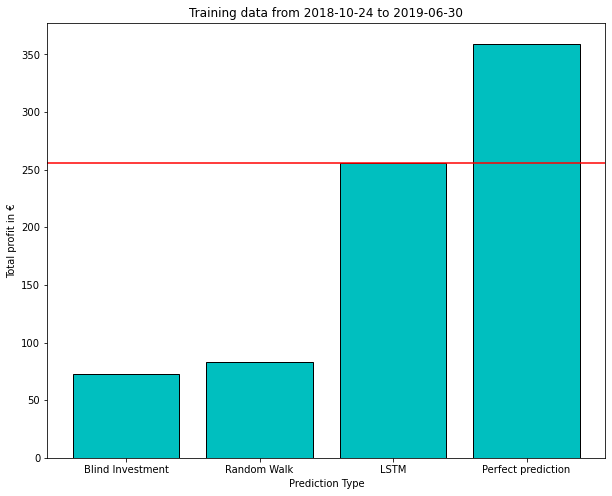

In [230]:

x = ['Blind Investment', 'Random Walk', 'LSTM', 'Perfect prediction']
N=5 # N days
t=50 # We invest 50 times N days each
s=1500 #Starting date: day 1200 or "2018-10-24"
inv=100 #we decide to invest 100€ 

returns = perf(N, t, s,inv, C) #C is our data samples
x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(10,8))
plt.bar(x_pos, returns, color='c',edgecolor="black")
plt.xlabel("Prediction Type")
plt.ylabel("Total profit in €")
plt.title("Training data from 2018-10-24 to 2019-06-30")

plt.xticks(x_pos, x)
plt.axhline(returns[2], c='r')
plt.show()


As expected the LSTM model performs very well on test data. The random walk does slightly better than just blindly investing.

Now a more Recent example from 2020-01-17 till 2020-11-11

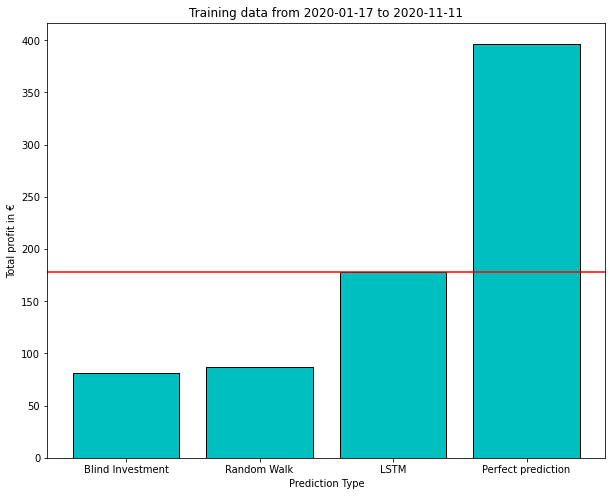

In [229]:
N=10
t=30
s=1950
inv=100 

returns = perf(N, t, s,inv, C) #C is our data samples

plt.figure(figsize=(10,8))
plt.bar(x_pos, returns,color='c',edgecolor="black")
plt.xlabel("Prediction Type")
plt.ylabel("Total profit in €")
plt.title("Training data from 2020-01-17 to 2020-11-11")

plt.xticks(x_pos, x)
plt.axhline(returns[2], c='r')
plt.show()

The results on training data look very promising, but this is to be expected.

### Results on testdata

We look at various testsamples.

In [21]:
url = 'https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/BTC-USDMAX.csv'
BTCMAX = pd.read_csv(url,skip_blank_lines=False).dropna()[["Date","Volume","Open","Close"]]
testdata = pd.concat([BTCMAX["Date"], (BTCMAX["Open"] - BTCMAX["Close"])/(BTCMAX["Open"]+BTCMAX["Close"] )], axis=1).set_index(BTCMAX.columns[0])
testdata = testdata.dropna()

Since we don't have that many test samples we need to take shorter time spans.

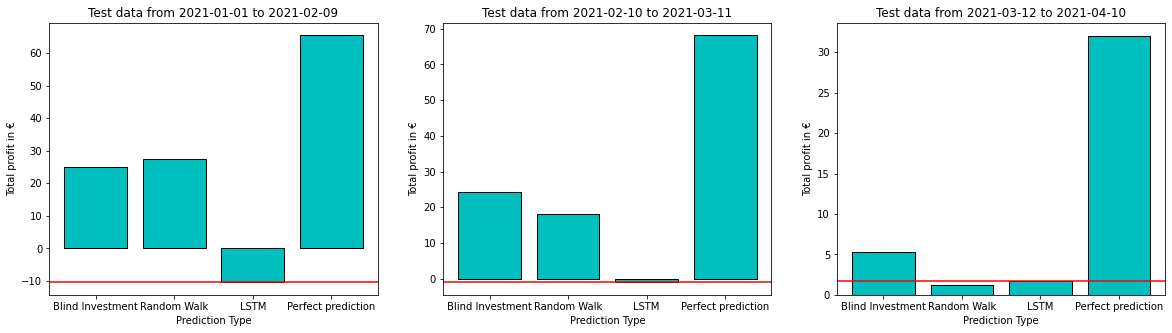

In [231]:
N=5
t=6
s=2310
inv=100 
returns = perf(N, t, s,inv, testdata) 

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.bar(x_pos, returns, color='c',edgecolor="black")
plt.xlabel("Prediction Type")
plt.ylabel("Total profit in €")
plt.title("Test data from 2021-01-01 to 2021-02-09")
plt.xticks(x_pos, x)
plt.axhline(returns[2], c='r')

s=2340
returns = perf(N, t, s,inv, testdata) 

plt.subplot(1,3,2)
plt.bar(x_pos, returns, color='c',edgecolor="black")
plt.xlabel("Prediction Type")
plt.ylabel("Total profit in €")
plt.title("Test data from 2021-02-10 to 2021-03-11")
plt.xticks(x_pos, x)
plt.axhline(returns[2], c='r')

s=2370
returns = perf(N, t, s,inv, testdata) 

plt.subplot(1,3,3)
plt.bar(x_pos, returns, color='c',edgecolor="black")
plt.xlabel("Prediction Type")
plt.ylabel("Total profit in €")
plt.title("Test data from 2021-03-12 to 2021-04-10")
plt.xticks(x_pos, x)
plt.axhline(returns[2], c='r')

plt.show()

We see that on testdata the LSTM model is basically useless and underperforms in every sample. Also the blind investment seems to perform better than our random walk  forecast. This is ok, the point of the random walk  forecast is not to make greater profits but mitigate great losses.

Our samplesize is very small but we can test our LSTM model on LTC which correlates highly with our testdata.

In [24]:
url = 'https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/LTC-USD.csv'
LTC = pd.read_csv(url,skip_blank_lines=False).dropna()[["Date","Volume","Open","Close"]]
testdata2 = pd.concat([LTC["Date"], (LTC["Open"] - LTC["Close"])/(LTC["Open"]+LTC["Close"] )], axis=1).set_index(LTC.columns[0])
testdata2 = testdata2.dropna()

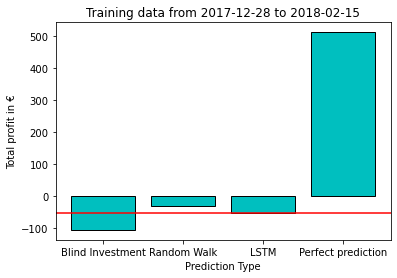

In [139]:
N=5
t=50
s=1200
inv=100 

returns = perf(N, t, s,inv, testdata2) #C is our data samples
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, returns, color='c',edgecolor="black")
plt.xlabel("Prediction Type")
plt.ylabel("Total profit in €")
plt.title("Training data from 2017-12-28 to 2018-02-15")

plt.xticks(x_pos, x)
plt.axhline(returns[2], c='r')
plt.show()

While The model performs better than Blind investment it is still very weak compared to the performance on training data and doesn't even outperform our simple random walk forecasting.

### Why is this happening?

Investing based purely on statistical analysis is not a very good idea to begin with, there are many outside factors in the stock market coming into place that are impossible to see purely by statistical methods. Such methods should be used to assess risk instead, thereby aiding in decision making. 
The LSTM basically looks at input data and returns an output that, mashed together with the input, would be similar to something within the training samples.
This works excellent when we have a seasonal time series or something with recurring patterns like language. There is no such thing as recurring pattern in the stock market, there are certainly seasonal Trends but they also don't repeat themselves (they are one time flavours so to say) so the things that the LSTM model could predict are non existent.
